In [3]:
sc

<SparkContext master=spark://galago-puhrez:7077 appName=PySparkShell>

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("Questions Investigation") \
    .getOrCreate()


In [5]:
from pyspark.sql.utils import AnalysisException
filepath = "../fixtures/transformed_daily_properties.csv"
try:
    propertiesDF = spark.read.format("csv")  \
        .option("inferSchema", "true")  \
        .option("header", "true")  \
        .load(filepath).cache()
except AnalysisException as e:
    print("Got an Analysis exception, please ensure %s exists" % filepath)

## What does the  neighborhood distribution look like?

In [6]:
neighborhoodDF = propertiesDF.select("Neighborhood").cache()
groupedByNeighborhoodDF = neighborhoodDF.groupBy("Neighborhood").count()
# 20 needed because args are positional
neighborhoodCount = groupedByNeighborhoodDF.count()
groupedByNeighborhoodDF.sort("count").show(neighborhoodCount, False)
print(neighborhoodCount, "neighborhoods")

+------------+-----+
|Neighborhood|count|
+------------+-----+
|Blueste     |2    |
|NPkVill     |9    |
|Veenker     |11   |
|BrDale      |16   |
|Blmngtn     |17   |
|MeadowV     |17   |
|SWISU       |25   |
|StoneBr     |25   |
|ClearCr     |28   |
|IDOTRR      |37   |
|Timber      |38   |
|NoRidge     |41   |
|Mitchel     |49   |
|Crawfor     |51   |
|BrkSide     |58   |
|SawyerW     |59   |
|NWAmes      |73   |
|Sawyer      |74   |
|NridgHt     |77   |
|Gilbert     |79   |
|Somerst     |86   |
|Edwards     |100  |
|OldTown     |113  |
|CollgCr     |150  |
|NAmes       |225  |
+------------+-----+

25 neighborhoods


In [7]:
# let's graph them
%matplotlib inline
import seaborn as sns
# this is dangerous if there neighborhoodDF is big
neighborhoods = neighborhoodDF.toPandas()

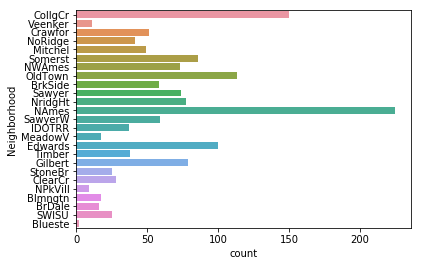

In [8]:
sns.countplot(y="Neighborhood", data=neighborhoods)

## What's the average sale price per neighborhood?

In [9]:
import pyspark.sql.functions as funcs
salesPriceByNeighborhoodDF = propertiesDF  \
    .groupBy("Neighborhood") \
    .agg(dict(SalePrice="avg", Neighborhood="count"))  \
    .select("Neighborhood",
            funcs.col("avg(SalePrice)").cast("int").alias("Avg Sales Price"),
            funcs.col("count(Neighborhood)").alias("Num of Properties"))

# Added count for more context, 
# We can see how distributed the portfolio is across economic levels
salesPriceByNeighborhoodDF.sort("Avg Sales Price").show(neighborhoodCount, False)

+------------+---------------+-----------------+
|Neighborhood|Avg Sales Price|Num of Properties|
+------------+---------------+-----------------+
|MeadowV     |98576          |17               |
|IDOTRR      |100123         |37               |
|BrDale      |104493         |16               |
|BrkSide     |124834         |58               |
|Edwards     |128219         |100              |
|OldTown     |128225         |113              |
|Sawyer      |136793         |74               |
|Blueste     |137500         |2                |
|SWISU       |142591         |25               |
|NPkVill     |142694         |9                |
|NAmes       |145847         |225              |
|Mitchel     |156270         |49               |
|SawyerW     |186555         |59               |
|NWAmes      |189050         |73               |
|Gilbert     |192854         |79               |
|Blmngtn     |194870         |17               |
|CollgCr     |197965         |150              |
|Crawfor     |210624

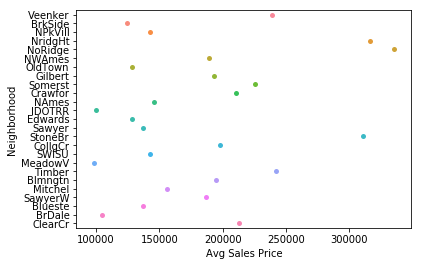

In [10]:
# let's plot it!

salesPriceByNeighborhood = salesPriceByNeighborhoodDF.toPandas()
sns.stripplot(x="Avg Sales Price", y="Neighborhood", 
              data=salesPriceByNeighborhood)

# What're the ten most expensive houses like?

In [11]:
# Note that there's no way to determine how many bedrooms are in the basement
# since the "BedroomAbvGr" column exludes them and there's no "BedroomBlwGr" column

columnsOfInterest = [
    "SalePrice",
    "Neighborhood",
    "BldgType",
    "HouseStyle",
    "OverallCond",
    "YearBuilt",
    "BedroomAbvGr",
    "GarageArea",
    "PoolArea"
    
]
propertiesDF.sort(funcs.desc('SalePrice')).select(*columnsOfInterest).show(10)

+---------+------------+--------+----------+-----------+---------+------------+----------+--------+
|SalePrice|Neighborhood|BldgType|HouseStyle|OverallCond|YearBuilt|BedroomAbvGr|GarageArea|PoolArea|
+---------+------------+--------+----------+-----------+---------+------------+----------+--------+
|   755000|     NoRidge|    1Fam|    2Story|          6|     1994|           4|       832|       0|
|   745000|     NoRidge|    1Fam|    2Story|          5|     1996|           4|       813|     555|
|   625000|     NoRidge|    1Fam|    2Story|          5|     1995|           4|       807|       0|
|   611657|     NridgHt|    1Fam|    1Story|          5|     2009|           2|       820|       0|
|   582933|     NridgHt|    1Fam|    2Story|          5|     2008|           4|      1020|       0|
|   556581|     StoneBr|    1Fam|    2Story|          5|     2005|           4|       716|       0|
|   555000|     NridgHt|    1Fam|    1Story|          5|     2008|           2|       672|       0|


# What're the ten least expensive houses like?

In [12]:
bottom10 = propertiesDF.sort(funcs.asc('SalePrice')).select(*columnsOfInterest).show(10)

+---------+------------+--------+----------+-----------+---------+------------+----------+--------+
|SalePrice|Neighborhood|BldgType|HouseStyle|OverallCond|YearBuilt|BedroomAbvGr|GarageArea|PoolArea|
+---------+------------+--------+----------+-----------+---------+------------+----------+--------+
|    34900|      IDOTRR|    1Fam|    1Story|          5|     1920|           2|         0|       0|
|    35311|      IDOTRR|    1Fam|    1Story|          3|     1949|           1|       308|       0|
|    37900|     OldTown|    1Fam|    1.5Fin|          6|     1910|           2|         0|       0|
|    39300|     BrkSide|    1Fam|    1Story|          3|     1946|           1|         0|       0|
|    40000|      IDOTRR|    1Fam|    2Story|          4|     1920|           3|       250|       0|
|    52000|     BrkSide|    1Fam|    1Story|          6|     1935|           2|         0|       0|
|    52500|     OldTown|    1Fam|    1Story|          4|     1941|           2|         0|       0|


# Among the houses with the best overall condition, what percent have a garage area bigger than 1000sqft

In [13]:
from pyspark.sql import Window

# Need to make a DF with the largest max for filtering inner join later
maxCond = propertiesDF.select(funcs.max('OverallCond').alias('maxCond'))

# I need an infinitely large window if I want to compute the percentage
# against the whole data set
window = Window.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

bestHousesByVeryBigGarageDF = propertiesDF.join(
    maxCond, 
    propertiesDF.OverallCond == maxCond.maxCond, 
        'inner')  \
    .groupBy('GarageAreaGT1000SqFt')  \
    .count()  \
    .withColumn('total', funcs.sum('count').over(window)) \
    .withColumn('Percentage',
                funcs.bround(funcs.col('count') / funcs.col('total') * 100, 2)) \
    .drop('count').drop('total') 

bestHousesByVeryBigGarageDF.show()

+--------------------+----------+
|GarageAreaGT1000SqFt|Percentage|
+--------------------+----------+
|                true|      4.55|
|               false|     95.45|
+--------------------+----------+



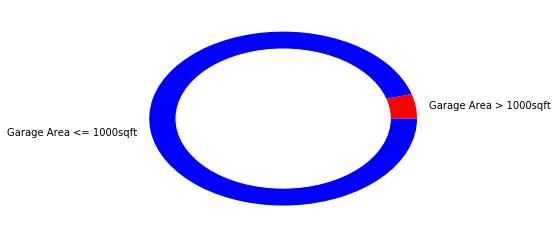

In [14]:
# Let's graph it with a donut plot!
import matplotlib.pyplot as plt
counts, groups = [], []
for row in bestHousesByVeryBigGarageDF.collect():
    counts.append(row.Percentage)
    groups.append('Garage Area > 1000sqft' 
                  if row.GarageAreaGT1000SqFt
                 else 'Garage Area <= 1000sqft')
inner_circle = plt.Circle((0, 0), 0.8, color="white")
plt.pie(counts, labels=groups, colors=['red', 'blue'])
donut_plt = plt.gcf()
donut_plt.gca().add_artist(inner_circle)
plt.show()

# How big is my frontage?

In [15]:
# Since  I can't tell how big your frontage is, I'll tell you want the average frontage is

# Some entries are missing frontages, 
# so in intial attempt a  Data processing step we nulled them. 
# How many of them are null?
nulls = propertiesDF.filter(propertiesDF.LotFrontage.isNull()).count() 
print("LotFrontage nulls:", nulls)
# what percentage of our data is that?
perc = round(nulls / propertiesDF.count() * 100, 2)
print("% of null LotFrontages:", perc)

LotFrontage nulls: 259
% of null LotFrontages: 17.74


Let's try and figure out how to impute Frontage. Given its definition, we can take LotShape and LotArea as potential correlates, and impute LotFrontage from them.
Plotting might confirm these ideas

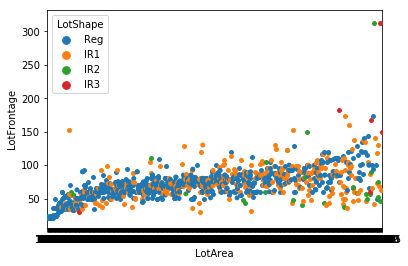

In [16]:
# This one takes a minute
frontageDF = propertiesDF.select("LotFrontage", "LotArea", "LotShape")
properties = frontageDF.toPandas()
sns.stripplot(y="LotFrontage", x="LotArea", hue="LotShape", data=properties)

Since we can see that the LotArea correlates (i.e. moves with) LotFrontage, (mostly) even across LotShapes, let's use LotArea to impute LotFrontage


In [17]:
from pyspark.ml.feature import Imputer
imputableFrontageFG = frontageDF.select(frontageDF.LotFrontage.cast('float'), frontageDF.LotArea.cast('float'))

imputer = Imputer(
    inputCols=imputableFrontageFG.columns,
    outputCols=imputableFrontageFG.columns            
)

imputedDF = imputer.fit(imputableFrontageFG).transform(imputableFrontageFG)

# Let's make sure that we no longer have nulls for Frontage
assert not imputedDF.filter(imputedDF.LotFrontage.isNull()).count()

# For curiousity's sake, let's see how the average moved
print("San Impution")
propertiesDF.select(funcs.round(funcs.avg('LotFrontage'), 2)).show()
print("With Mean Impution")
imputedDF.select(funcs.round(funcs.avg('LotFrontage'), 2)).show()

San Impution
+--------------------------+
|round(avg(LotFrontage), 2)|
+--------------------------+
|                     70.05|
+--------------------------+

With Mean Impution
+--------------------------+
|round(avg(LotFrontage), 2)|
+--------------------------+
|                     70.05|
+--------------------------+



Neglibly I see, let's try with a median stategy instead of mean as is Imputer's default

In [18]:
medianImputer = Imputer( 
    inputCols=imputableFrontageFG.columns,
    outputCols=imputableFrontageFG.columns,
    strategy='median'
)

imputedDF = imputer.fit(imputableFrontageFG).transform(imputableFrontageFG)


medianImputedDF = medianImputer.fit(imputableFrontageFG).transform(imputableFrontageFG)

# Let's make sure that we no longer have nulls for Frontage
assert not medianImputedDF.filter(medianImputedDF.LotFrontage.isNull()).count()

print("Sans Impution")
propertiesDF.select(funcs.round(funcs.avg('LotFrontage'), 2)).show()
print("With Median Impution")
medianImputedDF.select(funcs.round(funcs.avg('LotFrontage'), 2)).show()

Sans Impution
+--------------------------+
|round(avg(LotFrontage), 2)|
+--------------------------+
|                     70.05|
+--------------------------+

With Median Impution
+--------------------------+
|round(avg(LotFrontage), 2)|
+--------------------------+
|                     69.86|
+--------------------------+



With this research we can inform how we transform our data to impute LotFrontage

# Which neighborhood would you advice for a family of 5 with 2 cars and 170,000USD?

The general approach here is to present the top 10 neighboorhoods by Bedrooms. Why bedrooms? Because depending on the family, certain members may want to sleep in the same room. At a minimum we assume 2 bedrooms, seperating a master's for the parents and another for the children.

In [19]:
recommendationsDF = propertiesDF  \
    .filter(funcs.col('SalePrice') < 170000)  \
    .filter(funcs.col('GarageCars') >= 2)  \
    .filter(funcs.col('BedroomAbvGr') >= 2)  \
    .groupBy('Neighborhood', 'BedroomAbvGr')  \
    .agg(dict(Neighborhood='count', OverallCond='avg', SalePrice='avg', OverallQual='avg')) \
    .select('Neighborhood',
            'BedroomAbvGr',
            funcs.round('avg(OverallQual)', 2).alias('Avg Quality'),
            funcs.round('avg(OverallCond)', 2).alias('Avg Condition'),
            funcs.col('count(Neighborhood)').alias('Num of Properties'),
            funcs.round('avg(SalePrice)', 2).alias('Avg Sale Price')) \
    .orderBy(['Avg Condition', 'Avg Quality', 'Num of Properties', 'BedroomAbvGr'],
            ascending=False)
    
recommendationsDF.show(10)

+------------+------------+-----------+-------------+-----------------+--------------+
|Neighborhood|BedroomAbvGr|Avg Quality|Avg Condition|Num of Properties|Avg Sale Price|
+------------+------------+-----------+-------------+-----------------+--------------+
|       SWISU|           3|        7.0|          9.0|                1|      155000.0|
|     BrkSide|           2|        6.0|         7.33|                3|      122300.0|
|     Gilbert|           4|        8.0|          7.0|                1|      164000.0|
|     ClearCr|           3|        6.0|          7.0|                1|      155000.0|
|     Crawfor|           2|        5.0|          7.0|                1|      163500.0|
|     OldTown|           3|       5.38|         6.62|               13|     137607.69|
|     BrkSide|           3|        5.5|          6.6|               10|      140440.0|
|     OldTown|           4|       5.44|         6.33|                9|     131644.44|
|     OldTown|           2|       5.29|    

Given the above data, I recommend if the family is cool with having three bedrooms that they run as fast as possible to SWISU to checkout the only property there as it's a bit under their budget, of the best condition possible, and has enough bedrooms. If they want a master bedroom for parents and a room for each of the other members, Gilbert has the best quality and is in great condition, though it's very close to their budget. Oldtown and Crawfor both have suitable listings, of better value, though the (slightly) sacrifice quality.

If the family wants a bedroom for each member, these are the only neighborhoods that'll satisfy them.


In [20]:
recommendationsDF.filter(funcs.col('BedroomAbvGr') == 5).select('Neighborhood').show()

+------------+
|Neighborhood|
+------------+
|       NAmes|
|     OldTown|
|     MeadowV|
+------------+



# Some interesting insight
While one would think that there's a correlation between Quality, Condition and Price. That's not necessarily true. As the graphs below will show, while there is a correlation between Price and Quality, Condition doesn't correlate with either. Leading one to believe that houses in need of house's value is determined more by the quality of its build than its current condition, intuitively because it's easier and more cost efficient to fix up a rundown home than renovate shoddy construction.

In [21]:
curiousDF = propertiesDF  \
    .groupBy("Neighborhood") \
    .agg(dict(OverallCond='avg', SalePrice='avg', OverallQual='avg')) \
    .select('Neighborhood',
            funcs.round('avg(OverallQual)', 2).alias('Avg Quality'),
            funcs.round('avg(OverallCond)', 2).alias('Avg Condition'),
            funcs.round('avg(SalePrice)', 2).alias('Avg Sale Price'))
curious = curiousDF.toPandas()

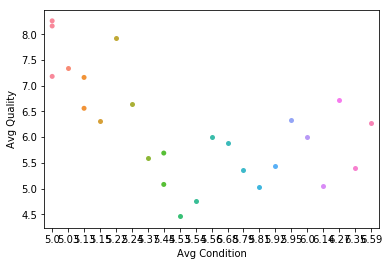

In [22]:
sns.stripplot(y="Avg Quality", x="Avg Condition", data=curious)

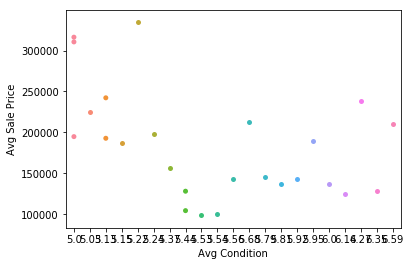

In [23]:
sns.stripplot(y="Avg Sale Price", x="Avg Condition", data=curious)

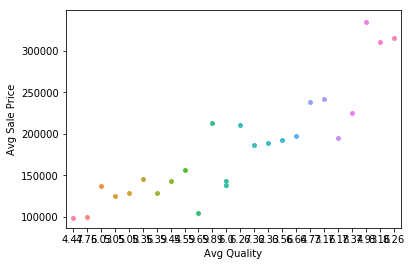

In [24]:
sns.stripplot(y="Avg Sale Price", x="Avg Quality", data=curious)